In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from DL_attacks import DL, user, utils, ops_on_vars_list
from exp_setups import *
from exp_setups.CIFAR10 import * 
from DL_attacks.model import binary_accuracy
from DL_attacks.attacker import Attacker
from DL_attacks.model import resnet20
from DL_attacks.user import User

rng_seed = 0
np.random.seed(rng_seed)
tf.random.set_seed(rng_seed)

# Setup

In [2]:
CDL = DL.Torus
ATTACKER = Attacker
MODEL = resnet20
nu = 16
batch_size = 64
learning_rate = 1.
size_local_ds = 100

## Setup Topology and DL framework

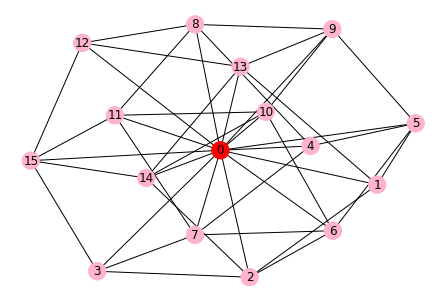

In [3]:
train_sets, test_set, x_shape, num_class = utils.setup_data(
    load_dataset,
    nu,
    size_local_ds,
    batch_size,
    size_testset,
    type_partition
)

make_model = utils.setup_model(MODEL, [x_shape, num_class, init_lr, []], model_same_init)
dl = CDL(graph_properties)
dl.setup(nu, make_model, train_sets, test_set, USER, ATTACKER)

# connecting attacker to everyone
att = dl.attacker
for v in dl.U:
    if not att is v: 
        att.neighbors.add(v)    
        v.neighbors.add(att)

dl.model_graph();

# Run protocol (two rounds are enough)

In [4]:
dl()
dl()

# Map topology 

In [5]:
from DL_attacks.find_nn import find_nn

# for each attack neighbor, infere neighbors
adv = dl.attacker 
nn = adv.neighbors.copy()

# assumed bound on the number of victim's neighbors during the search
number_of_neighbors_range = [3, 4, 5, 6, 7]

guessed_first_try = []

print("Start enumeration....")
for victim in nn:
    # Just a POC. Note that this is not efficient. One guessed the neighbors of user, this information can be used to reduce the complexity of learning the one of the other users
    solution_rank, ground_truth, s_scores = find_nn(dl, victim, number_of_neighbors_range)
    print(f"\t{victim.name}'s neighbors guessed in {solution_rank}.")
    print(f"\t\t First guess is {s_scores[0][1]} | ground truth is {ground_truth}\n")
    
    guessed_first_try.append(solution_rank==0) 
    
print("Complete.")
accuracy = np.array(guessed_first_try).mean() * 100
print(f"-> Global Accuracy: {accuracy}%")

Start enumeration....
	11's neighbors guessed in 0.
		 First guess is [0, 7, 8, 10, 11, 15] | ground truth is [0, 7, 8, 10, 11, 15]

	7's neighbors guessed in 0.
		 First guess is [0, 3, 4, 6, 7, 11] | ground truth is [0, 3, 4, 6, 7, 11]

	15's neighbors guessed in 0.
		 First guess is [0, 3, 11, 12, 14, 15] | ground truth is [0, 3, 11, 12, 14, 15]

	9's neighbors guessed in 0.
		 First guess is [0, 5, 8, 9, 10, 13] | ground truth is [0, 5, 8, 9, 10, 13]

	12's neighbors guessed in 0.
		 First guess is [0, 8, 12, 13, 15] | ground truth is [0, 8, 12, 13, 15]

	6's neighbors guessed in 0.
		 First guess is [0, 2, 5, 6, 7, 10] | ground truth is [0, 2, 5, 6, 7, 10]

	14's neighbors guessed in 0.
		 First guess is [0, 2, 10, 13, 14, 15] | ground truth is [0, 2, 10, 13, 14, 15]

	8's neighbors guessed in 0.
		 First guess is [0, 4, 8, 9, 11, 12] | ground truth is [0, 4, 8, 9, 11, 12]

	10's neighbors guessed in 0.
		 First guess is [0, 6, 9, 10, 11, 14] | ground truth is [0, 6, 9, 10, 11, 14